**Initialization of Salvus**

**ToDo**
- plot time-space traces (i.e. fixed y and varying x against time) 
- plot snapshots of the wavefield at specific times in x-y
- check wavelet so that it's at the right time

In [1]:
'''Salome Bachmann - Research Module in Applied Geophysics

Setting up a purely acoustic simulation with a point source using Salvus in homogenous media in 2D'''


# Imports (taken from salvus tutorials)
import os

SALVUS_FLOW_SITE_NAME = os.environ.get("macbook", "local") # Site name given in the installation of Salvus flow
PROJECT_DIR = "simulation_pure_acoustic"
import pathlib
import numpy as np
import salvus.namespace as sn
import xarray as xr
import salvus.namespace as sn
from salvus.project.tools.processing import block_processing
from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)
import matplotlib.pyplot as plt
import obspy



--> Server: 'https://l.mondaic.com/licensing_server', User: 'salome.bachmann', Group: 'ETHZ_ERDW_EEG'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.52 seconds]


**Setup of Model domain**

In [2]:
# Setup of the model domain as a box --> IS THIS CORRECT OF SHOULD THE GEOMETRY BE DIFFERENT ???????
from xml.parsers.expat import model


d = sn.domain.dim2.BoxDomain(x0=0.0, x1=2000.0, y0=0.0, y1=1000.0) 

# Initilaize project from domain 
p = sn.Project.from_domain(path=PROJECT_DIR, domain=d, load_if_exists=True)

# Delete previous events if re-running the notebook
#p.events.delete(event_name="event_acoustic_hom")

# Also delete previous model configurations if re-running the notebook
path = pathlib.Path(PROJECT_DIR) / "INTERNAL" / "ENTITIES" / "SIMULATION_CONFIGURATIONS"
for file in path.glob("pure_acoustic_simulation.json"):
    file.unlink()






Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

[2025-12-30 12:15:58,888] INFO: Loading project from simulation_pure_acoustic.


**Setup of acoustic (explosive source) and strain recievers**
Point vector source because from an explosion the force radiates outward from the explosion point

In [3]:
# Source setup in the center of the model domain 
src = sn.simple_config.source.cartesian.VectorPoint2D(
    x=500.0, y=500.0, fx=1e10, fy=1e10 # fx and fy are the x and y components of the force in N I DONT KNOW WHAT VALUES THESE SHOULD BE --> RESEARCH MORE
)

# Reciever setup - strain reciebvers along the surface
recs = [
    sn.simple_config.receiver.cartesian.Point2D(
        y=1000, # Change this if recievers are buried 
        x=x,
        network_code="xx",
        station_code=f"REC{i + 1}",
        fields=["strain" ,"stress"]
    )
    for i, x in enumerate(np.linspace(1010.0, 1410.0, 10))
]

# Add sources and recievers to propject
p.add_to_project(sn.Event(event_name="event_acoustic_hom", sources=src, receivers=recs))

[2025-12-30 12:15:58,900] INFO: An event with name 'event_acoustic_hom' and identical content already exists in the project. Nothing will be done.


**Running the simulation, using parameters for snow**
Using an isotropic elastic model because there is only one material present which is assumed to be homogenous. Parameters are density of 800kg/m^3, vp of 300m/s, vs of 150m/s. Values were taken from https://tc.copernicus.org/articles/15/5805/2021/ table 2 for fresh snow

In [4]:
mc = sn.ModelConfiguration(
    background_model=sn.model.background.homogeneous.IsotropicElastic(
        rho=800.0, vp=300.0, vs=150
    )
)

**Wavelet configuration**

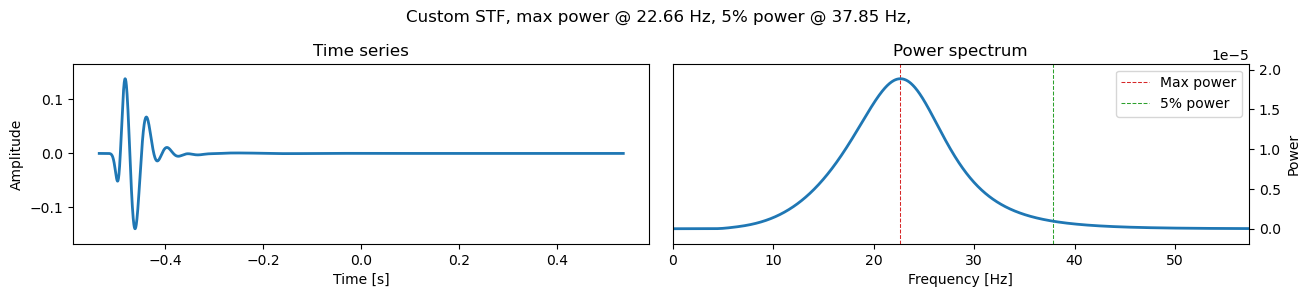

In [14]:
# changing center time of the wavelet according to post found on formum
# this uses bandpass filtering of the wavelet

wavelet = sn.simple_config.stf.Ricker(center_frequency=45.0)
ricker = wavelet.get_stf()
time_vector, wavelet_data = ricker[0], ricker[1]
sampling_rate = time_vector[31] - time_vector[30]
tr = obspy.Trace(wavelet_data, header={"delta": sampling_rate})
tr.trim(
    starttime=tr.stats.starttime,
    endtime=tr.stats.endtime + 1.0,
    pad=True,
    fill_value=0.0,
)
tr.filter("bandpass", freqmin=5.0, freqmax=25.0, corners=4)

# shifting the wavelet center by a given amount of seconds
shift_seconds = 0.5  # make center 0.5 s earlier

dt = float(time_vector[1] - time_vector[0])
fs = 1.0 / dt

# create custom wavelet with earlier start time
custom_wavelet = sn.simple_config.stf.Custom.from_array(
    array=tr.data,
    sampling_rate_in_hertz=fs,
    start_time_in_seconds=float(time_vector[0]) - shift_seconds,
)

# Define start and end time outside of event configuration so it can be reused
starttime=tr.stats.starttime
endtime=tr.stats.endtime + 1.0

# adjust event waveform window so it still covers the shifted wavelet
ec = sn.EventConfiguration(
    wavelet=custom_wavelet,
    waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
        start_time_in_seconds=float(starttime) - shift_seconds,
        end_time_in_seconds=float(endtime),  # extend end if needed
    ),
)

ec.wavelet.plot()

In [6]:
# # Event configuration taken from the tutorial, this centers the wavelet at t=0s
# ec = sn.EventConfiguration(
#     wavelet=sn.simple_config.stf.Ricker(center_frequency=14.5), # Center frequency is dependend on sourcve
#     waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
#         start_time_in_seconds=-1,
#         end_time_in_seconds=0,
#     ),
# )


**Plotting source spectrum and time series of source wavelet**
This is to check the source wavelet and make sure it's at the right time

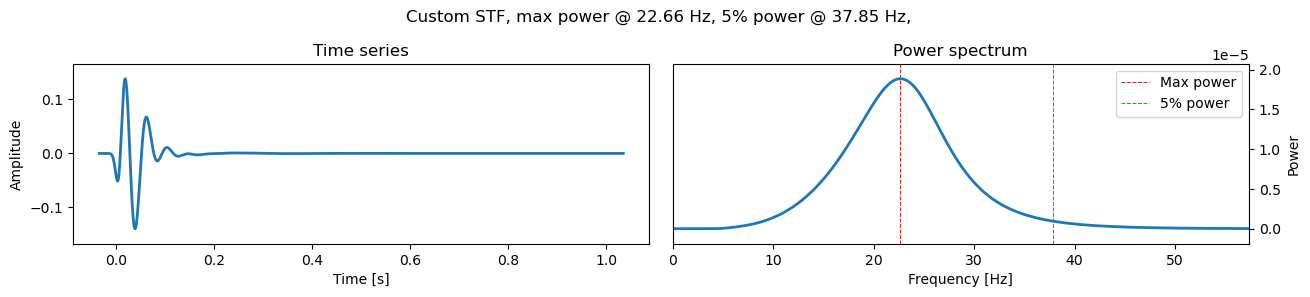

In [7]:
# Plotting source wavelet spectrum and time series usingh salvus function from. tutorial 1
ec.wavelet.plot()

**Simulation configuration**


In [8]:
p.add_to_project(
    sn.SimulationConfiguration(
        name="pure_acoustic_simulation",
        max_frequency_in_hertz=30.0,
        elements_per_wavelength=3.0,
        model_configuration=mc,
        event_configuration=ec,
    
       
    )
)

# Launich simulation
p.simulations.launch(
    ranks_per_job=2,
    site_name="macbook",
    events=p.events.list(),
    simulation_configuration="pure_acoustic_simulation",
    delete_conflicting_previous_results=True,

)

# Waiting for all simulations to be done
p.simulations.query(block=True)

[2025-12-30 12:15:59,168] INFO: Simulations of 2 event(s) are still running. They will not be submitted again.


VBox()

True

In [9]:
# # Printing the data to check which parts are there to avoid key error when plotting
# ed = p.waveforms.get("pure_acoustic_simulation", p.events.list())

# # try to get receiver data (no trailing dot in receiver name)
# try:
#     print(
#         ed[0].get_receiver_data(
#             receiver_name="XX.REC1", receiver_field="strain"
#         )
#     )
# except KeyError as e:
#     print("Receiver not found:", e)

# # Printing the keys available in the data
# try:
#     keys = ed[0].data.keys()
# except AttributeError:
#     try:
#         keys = list(ed[0].data)
#     except Exception:
#         keys = repr(ed[0].data)



**Visualization of wavelets**

/var/folders/5f/g3nknsgx6q3f91j5rd12vp240000gn/T/ipykernel_3080/2429442770.py:2: DeprecationWarning: The method get_data_cube is deprecated and superseded by `get_waveform_data_xarray`. On xarray.DataArray, one can naturally apply selections, filters and sorting. The `get_data_cube` method will be removed in a future release.
  p.waveforms.get(data_name="pure_acoustic_simulation", events=p.events.list())[1].plot(


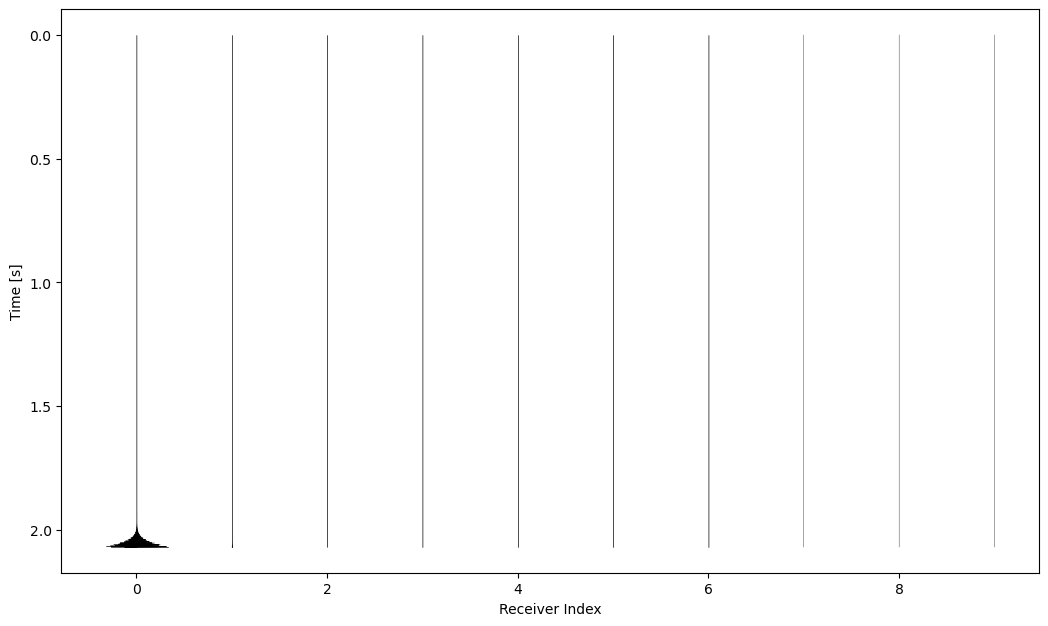

In [10]:
# Plotting a shotgather
p.waveforms.get(data_name="pure_acoustic_simulation", events=p.events.list())[1].plot(
    plot_types=("wiggles",), receiver_field="strain", component="1"
)

**Plotting the data using matplotlib so that plots can be adjusted**
this is done because in the plots using salvus' plot functions, the data is cut off

/var/folders/5f/g3nknsgx6q3f91j5rd12vp240000gn/T/ipykernel_3080/112485800.py:5: DeprecationWarning: The method get_data_cube is deprecated and superseded by `get_waveform_data_xarray`. On xarray.DataArray, one can naturally apply selections, filters and sorting. The `get_data_cube` method will be removed in a future release.
  times, values = ed[0].get_data_cube(


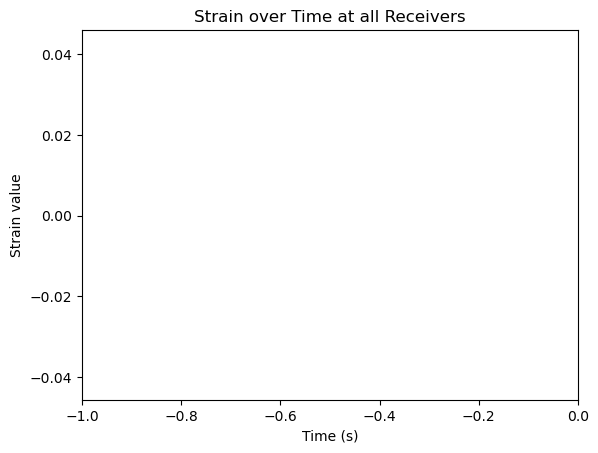

In [11]:
# Plotting the data manually to adjust visualization
ed = p.waveforms.get("pure_acoustic_simulation", p.events.list())

# Seperating the data by timesteps and values at the timestepts
times, values = ed[0].get_data_cube(
    receiver_field="strain", component="1"
)

# # check time values
# print("time max: ", times.max())
# # check waveform values 
# print(ec.waveform_simulation_configuration)
# print("start:", ec.waveform_simulation_configuration.start_time_in_seconds,
#       "end:", ec.waveform_simulation_configuration.end_time_in_seconds)


# Plotting times and their values using matplotlib so that visualization can be adjusted
plt.plot(times, values.T)
plt.xlabel("Time (s)")
plt.ylabel("Strain value")
plt.title("Strain over Time at all Receivers")
plt.xlim(-1,0)
plt.show()







**PLotting the individual reciever data to see what the data contains**

3 Trace(s) in Stream:
XX.REC2..0 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:02.069107Z | 1737.5 Hz, 3596 samples
XX.REC2..1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:02.069107Z | 1737.5 Hz, 3596 samples
XX.REC2..2 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:02.069107Z | 1737.5 Hz, 3596 samples


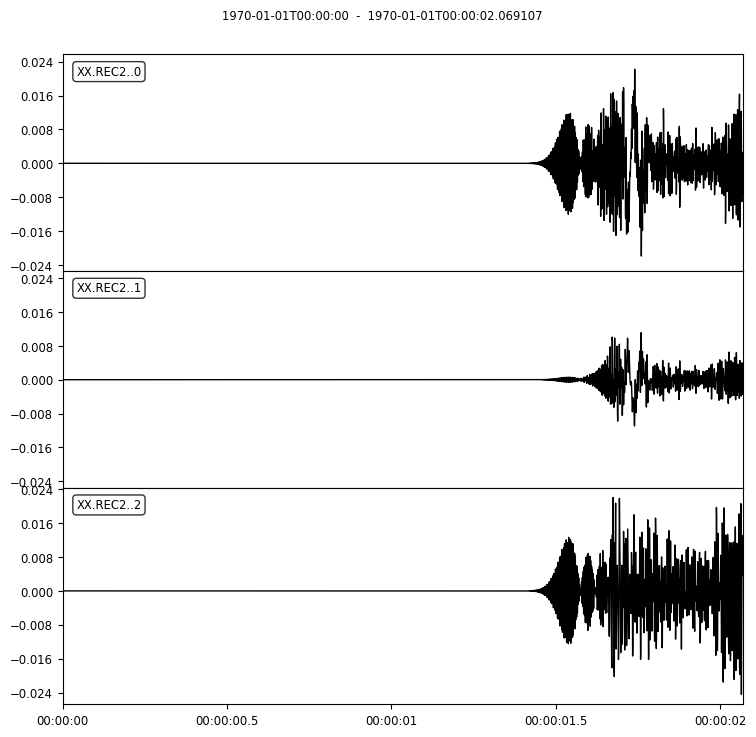

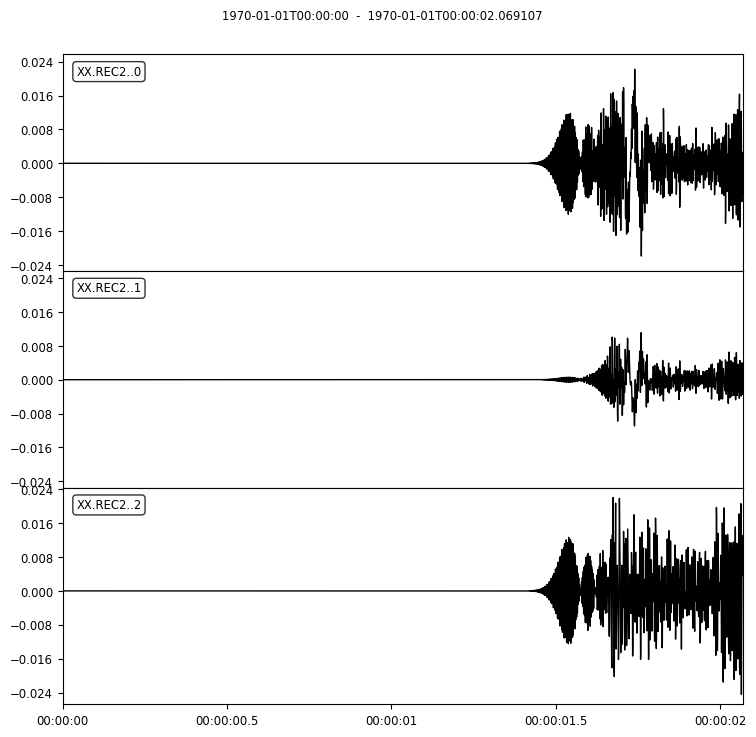

In [12]:
ed = p.waveforms.get("pure_acoustic_simulation", p.events.list())
print(
    ed[0].get_receiver_data(
        receiver_name="XX.REC2.", receiver_field="strain"
    )
)
ed[0].get_receiver_data(
    receiver_name="XX.REC2.", receiver_field="strain"
).plot()

**Plotting space-time traces with fixed y and varying y**

Plotting for receiver at x=1010.0
 -> plotting XX.REC1.


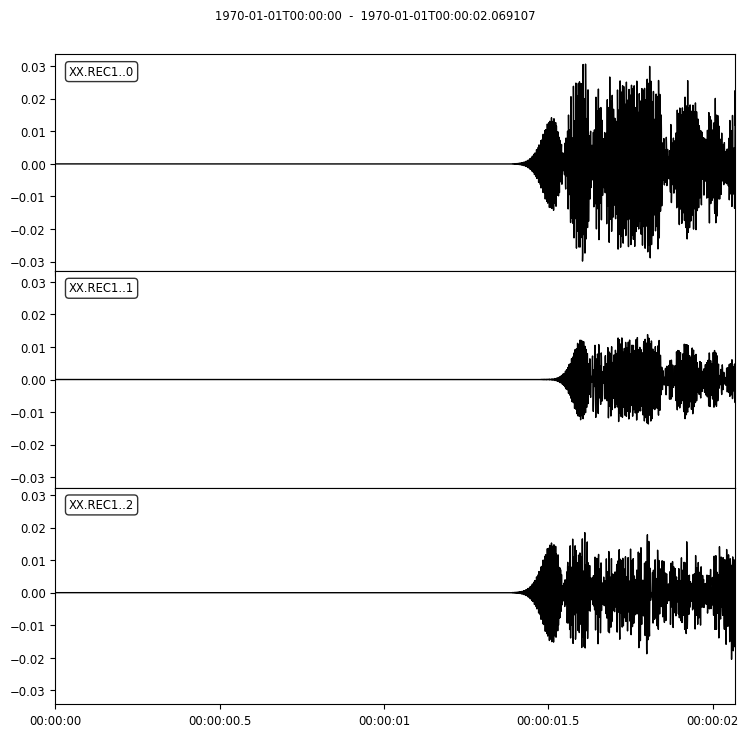

Plotting for receiver at x=1060.0
 -> plotting XX.REC2.


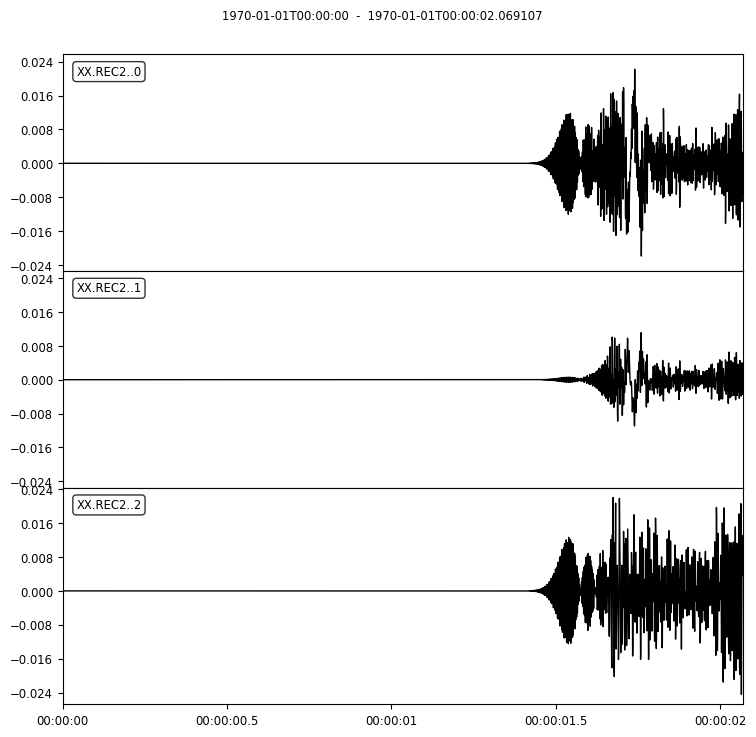

Plotting for receiver at x=1110.0
 -> plotting XX.REC3.


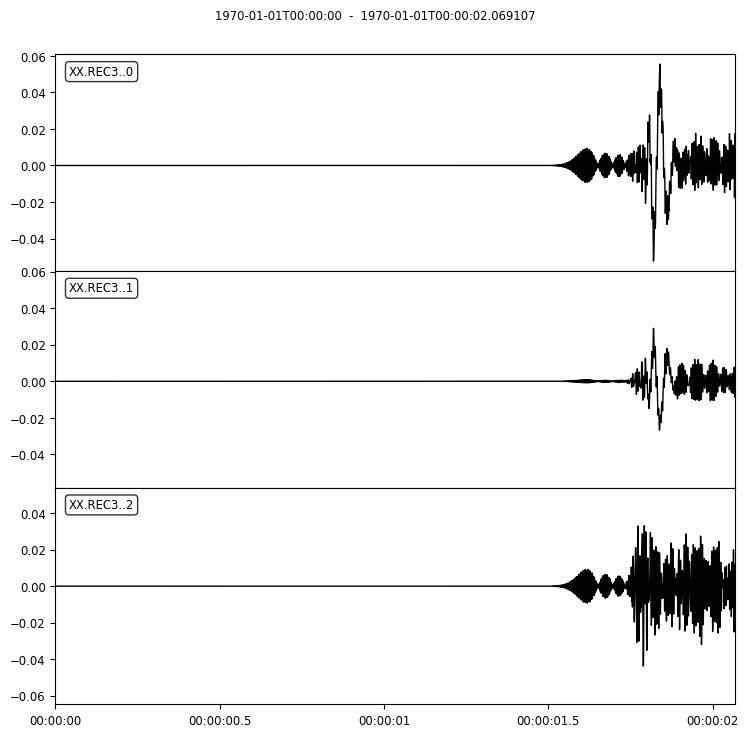

Plotting for receiver at x=1160.0
 -> plotting XX.REC4.


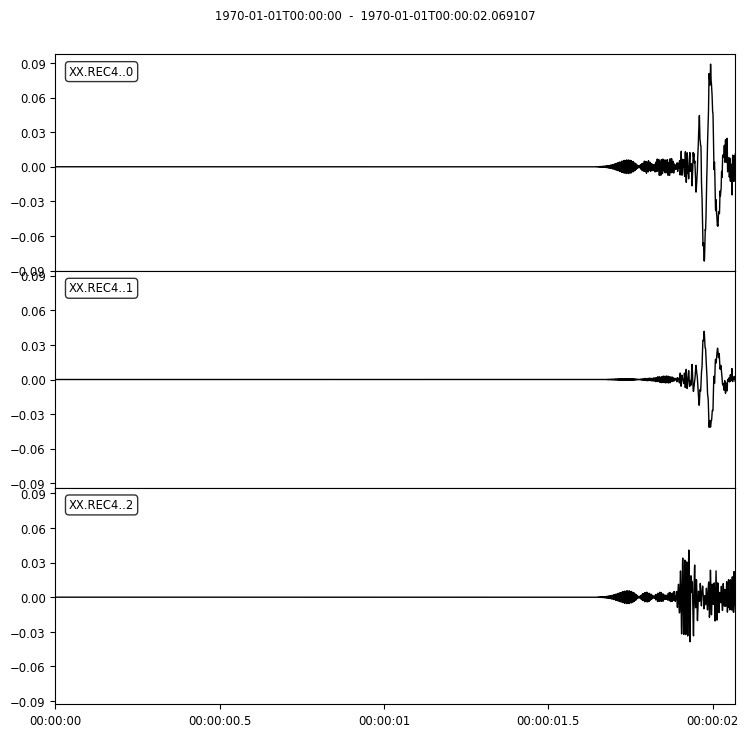

Plotting for receiver at x=1210.0
 -> plotting XX.REC5.


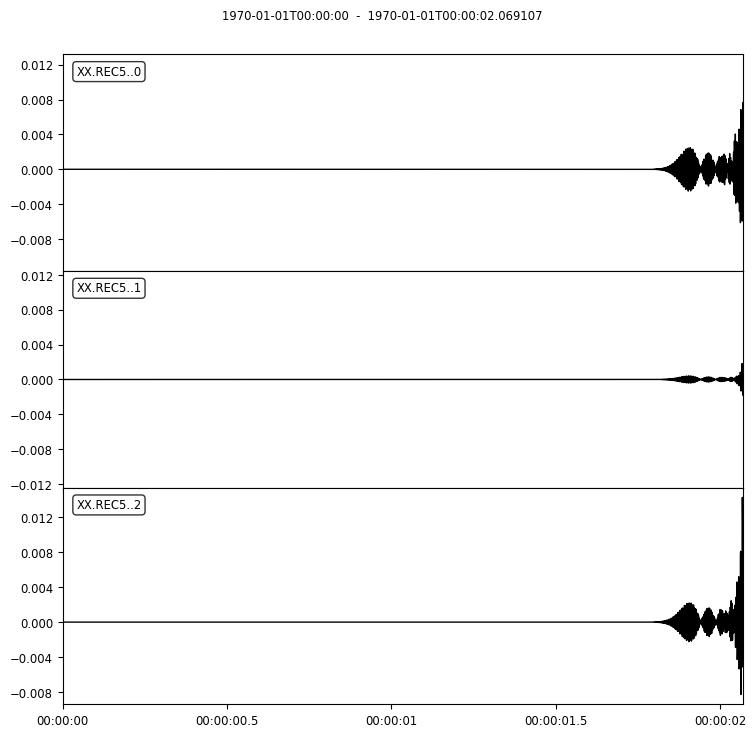

Plotting for receiver at x=1260.0
Plotting for receiver at x=1310.0
Plotting for receiver at x=1360.0
Plotting for receiver at x=1410.0


In [13]:
# varying x from the plots above in a loop
for x in np.linspace(1010.0, 1410.0, 9):
    print(f"Plotting for receiver at x={x}")
    # Plotting reciever numbers 1 to 5
    station = int(round((x - 1010.0) / (400.0 / 9))) + 1
    if 1 <= station <= 5:
        rn = f"XX.REC{station}."
        print(" -> plotting", rn)
        ed[0].get_receiver_data(receiver_name=rn, receiver_field="strain").plot()

